In [1]:
%pip install "git+https://github.com/facebookresearch/pytorch3d.git@stable"

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-rytswk2b
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-rytswk2b
  Running command git checkout -q 2f11ddc5ee7d6bd56f2fb6744a16776fab6536f7
  Resolved https://github.com/facebookresearch/pytorch3d.git to commit 2f11ddc5ee7d6bd56f2fb6744a16776fab6536f7
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for portalocker from https://files.pythonhosted.org/packages/17/9e/87671efcca80ba6203811540ed1f9c0462c1609d2281d7b7f53cef05da3d/portalocker-2.8.2-py3-none-any.whl.metadata


In [2]:
%pip install trimesh

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for trimesh from https://files.pythonhosted.org/packages/c4/28/f3c55fad13f908fdbedd763ed63bd07f409c32ef40bb0381d6107738fed3/trimesh-4.0.5-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 688.5/688.5 kB 6.9 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
%pip install 'git+https://github.com/marian42/mesh_to_sdf'

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/marian42/mesh_to_sdf to /tmp/pip-req-build-wuywt8xy
  Running command git clone --filter=blob:none --quiet https://github.com/marian42/mesh_to_sdf /tmp/pip-req-build-wuywt8xy
  Resolved https://github.com/marian42/mesh_to_sdf to commit 66036a747e82e7129f6afc74c5325d676a322114
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 8.9 MB/s eta 0:00:00:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 31.3 MB/s eta 0:00:00
  Obtaining dependency information for pyglet>=1.4.10 from https://files.pythonhosted.org/packages/e9/33/cbff7525a357c950e76717ea9741127a662a7ed49a92874897b8a4036db9/pyglet-2.0.10-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 55.5 MB/s eta 0:00:00:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 858.3/858.3 kB 34.6 MB/s eta 0:0

In [1]:
import os

os.environ['PYOPENGL_PLATFORM'] = 'egl'

from mesh_to_sdf import mesh_to_sdf, sample_sdf_near_surface
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import torch

# untilitis
from pytorch3d.utils import ico_sphere

# loss functions and regulaziers
from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency
)

# io utils
from pytorch3d.io import load_obj

# operations with data
from pytorch3d.ops import sample_points_from_meshes
# datastructures
from pytorch3d.structures import Meshes
from pytorch3d.renderer import TexturesVertex, Textures

# render
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras,
    DirectionalLights,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    HardPhongShader
)

# trimesh lib imports
import trimesh
from trimesh.voxel.creation import voxelize

In [2]:
# If you have got a CUDA device, you can use GPU mode
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.cuda.set_device(device)
else:
    device = torch.device('cpu')

In [3]:
path_to_model = "dog.obj"

# Trimesh dog .obj model
dog_trimesh = trimesh.load(path_to_model)

if isinstance(dog_trimesh, trimesh.Scene):
    dog_trimesh = dog_trimesh.dump(concatenate=True)

dog_trimesh.vertices -= dog_trimesh.center_mass
scaling = 2 / dog_trimesh.scale
dog_trimesh.apply_scale(scaling=scaling)

# Rainbow dog in trimesh
# for facet in dog_trimesh.facets:
#   dog_trimesh.visual.face_colors[facet] = trimesh.visual.random_color() 

# dog mesh in pytorch3d
verts, faces_idx, _ = load_obj(path_to_model)
faces = faces_idx.verts_idx

center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)

# Rainbow dog in pytorch3d
# verts_rgb = torch.rand_like(verts)[None]

textures = Textures(verts_rgb=verts_rgb.to(device))

# Create a Meshes object for the dog.
dog_mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)], 
    textures=textures
)

In [4]:
# Initialize an OpenGL perspective camera.
cameras = OpenGLPerspectiveCameras(device=device)

# We will also create a phong renderer. This is simpler and only needs to render one face per pixel.
raster_settings = RasterizationSettings(
    image_size=1024, 
    blur_radius=0, 
    faces_per_pixel=1, 
)

# We can add a point light in front of the object. 
#lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))
ambient_color = torch.FloatTensor([[0.0, 0.0, 0.0]]).to(device)
diffuse_color = torch.FloatTensor([[1.0, 1.0, 1.0]]).to(device)
specular_color = torch.FloatTensor([[0.1, 0.1, 0.1]]).to(device)
direction = torch.FloatTensor([[1, 1, 1]]).to(device)
lights = DirectionalLights(ambient_color=ambient_color,
                           diffuse_color=diffuse_color,
                           specular_color=specular_color,
                           direction=direction,
                           device=device)

phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(
        device=device, 
        cameras=cameras, 
        lights=lights
        )
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


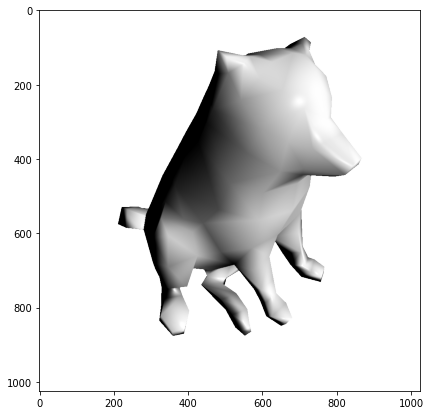

In [5]:
# Select the viewpoint using spherical angles  
distance = 2.0   # distance from camera to the object`
elevation = 40.0   # angle of elevation in degrees
azimuth = 0.0  # No rotation so the camera is positioned on the +Z axis. 

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device,at=((-0.02,0.1,0.0),))

# Render the dog providing the values of R and T. 
image_dog = phong_renderer(meshes_world=dog_mesh, R=R, T=T)

image_dog = image_dog.cpu().numpy()

plt.figure(figsize=(7, 7))
plt.imshow(image_dog.squeeze())
plt.grid(False)

## Воксельная модель

In [8]:
low_idx_dog = dog_trimesh.scale / 15
high_idx_dog = dog_trimesh.scale / 39
vox_high_dog = voxelize(dog_trimesh,pitch=high_idx_dog)

In [10]:
vox_high_dog.show()

# Облако точек

In [6]:
def plot_pointcloud(points, elev=70, azim=-70, title=""):
    # Sample points uniformly from the surface of the mesh.
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    #ax = Axes3D(fig)
    x, y, z = points
    ax.scatter3D(x, z, -y,marker='.')  
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(elev, azim)
    plt.show()

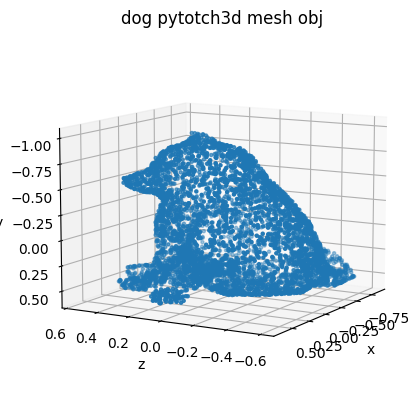

In [7]:
points = sample_points_from_meshes(dog_mesh, 5000)
points = points.clone().detach().cpu().squeeze().unbind(1)
plot_pointcloud(points, elev=190, azim=150, title='dog pytotch3d mesh obj')

# Функциональная модель

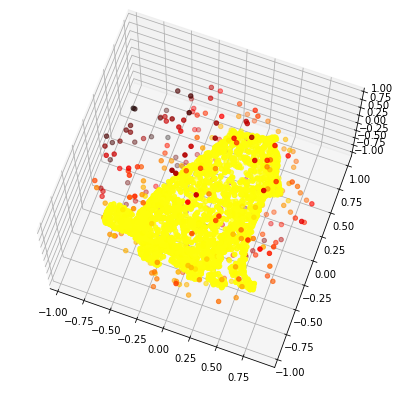

In [7]:
points, sdf = sample_sdf_near_surface(dog_trimesh, number_of_points=5000)
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection="3d")
ax.view_init(elev=70, azim=-70)
ax.scatter(points[:, 0], points[:, 1], zs=-points[:, 2], c=sdf, cmap="hot_r")